# Gradient Boosting Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

import scripts.load_data as load

%matplotlib inline

In [2]:
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.ensemble
import sklearn.model_selection
import sklearn.feature_selection
import sklearn.metrics

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from time import time

In [3]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [4]:
X,targets=load.load_training_spectra()

## Gradient Boosted Trees
Gradient boosted trees can be regarded as 
the smarter older sibling to the [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) 
ensemble method.  While Random Forest builds 
many trees in parallel, Gradient Boosting is a 
sequential process with a new tree formed at 
each stage.  Gradient Boosted Trees are iteratively 
corrected, with the residuals of the previous tree 
providing the basis for building the subsequent tree.  The 
user specifies the loss function to be optimized,
and here we use least squares regression,
the default loss function for scikit-learn's [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).  The
whole procedure can be regarded as a way of
applying [Gradient Descent](http://scikit-learn.org/stable/modules/sgd.html#sgd)
to [Decision Trees](http://scikit-learn.org/stable/modules/tree.html).

More info and intuition about gradient 
boosted trees can be found [here](http://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/).

To help speed up the task of training these trees, 
we perform some [dimensionality reduction](notebooklink) 
and feature selection below.

In [5]:
pca = skl.decomposition.PCA()
X_transformed = pca.fit_transform(X)


Scikit-learn's **GradientBoostingRegressor** 
doesn't work for multiple targets, 
so we will train for one target at a time.  SKL 
does handle multioutput for instances like this 
with MultiOutputRegressor, but it seems to make info 
about the gradient boosting regressor
(like feature importances) less accessible.  

For now we'll only look at one target, Ca.  To 
choose another target, change `output_column` 
in the cell below to equal your desired target.

In [6]:
#output_column options: "Ca","P","pH","SOC","Sand"
output_column="Ca"

y=targets[output_column]

An 80-20 train-test split is applied here to 
[cross-validate](nblink) our trained model.

In [7]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_transformed,y,test_size=0.2)

In [8]:
n_estimators=1000
clf=skl.ensemble.GradientBoostingRegressor(n_estimators=n_estimators)

Time to train the regressor on our training data.  If 
`n_estimators` is large, this may take a while.  

Typically,
1000 estimators on the spectral principal components
takes 80 seconds to complete.

In [9]:
start=time()
clf.fit(X_train,y_train.values.ravel())
print("GBR took %.2f seconds for %d estimators"
      % ((time() - start), n_estimators))

GBR took 81.16 seconds for 1000 estimators


In [10]:
y_pred = clf.predict(X_test)

Here are some scoring metrics for our first pass at this model:

In [11]:
skl.metrics.mean_squared_error(y_test,y_pred)

0.12064955735292023

In [12]:
skl.metrics.r2_score(y_test,y_pred)

0.82794144858651164

## Feature importances and selection

There are ways to save time without 
giving up model performance.  One 
way is by using GradientBoostingRegressor's 
**feature_importances** attribute, which 
can identify the most important features 
in determining a split, allowing us to 
cast out less important features.

Below we print out the highest ranking features
(remember, these are the 
numbered labels of our Principal Components):

In [13]:
importances=clf.feature_importances_
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1]):
for f in range(10):
    print("{:d}.  feature {:d} ({:f})".format(f+1,indices[f],importances[indices[f]]))

Feature ranking:
1.  feature 6 (0.015195)
2.  feature 3 (0.008805)
3.  feature 0 (0.008015)
4.  feature 8 (0.006579)
5.  feature 5 (0.006447)
6.  feature 4 (0.006067)
7.  feature 2 (0.005986)
8.  feature 7 (0.005845)
9.  feature 65 (0.005628)
10.  feature 32 (0.005108)


For the most part, the important features appear 
to also correspond to the the PCs that explain the most variance.  

However, it's important to note that
if dealing with a feature set 
with high correlation between features
(i.e. one that hasn't undergone PCA),
one shouldn't read too much into feature importances. 
While fine for saving time and reducing overfitting,
feature importances don't necessarily serve as an
interpretation for which features make
strong predictors for targets.  This is because
given two correlated features, the first one used
to determine a split will necessarily have a larger
impact on impurity reduction than the other.  Even
if both features serve as strong predictors,
the first feature will be ranked as much more
important.

For more information, you can read [this post](http://alexperrier.github.io/jekyll/update/2015/08/27/feature-importance-random-forests-gini-accuracy.html) 
describing feature engineering and selection in random forests - 
most insights will apply to GBRTs as well.

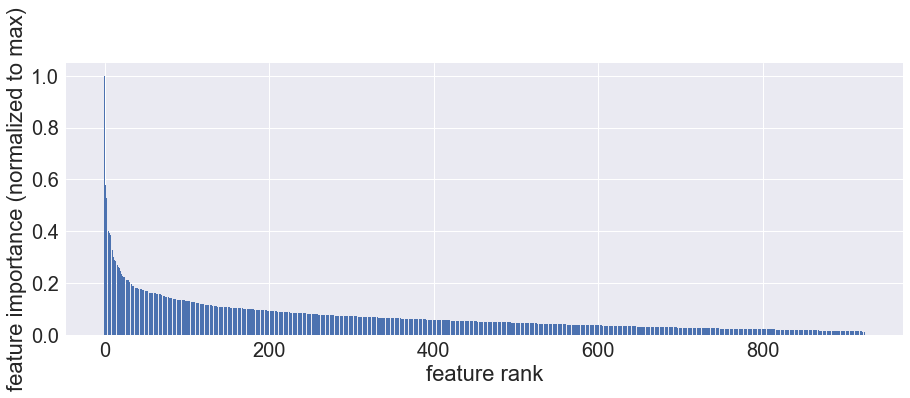

In [14]:
plt.figure(figsize=(15,5))
plt.bar(range(len(X_train)),
        clf.feature_importances_[indices[range(len(X_train))]]/clf.feature_importances_[indices[0]])
plt.xlabel('feature rank')
plt.ylabel('feature importance (normalized to max)');

Let's train GradientBoostingRegressor again,
this time only using important features.


The reduction in dimensionality will 
allow us to explore the hyperparameter 
space in a more timely fashion.  
Here we use skl's  **SelectFromModel**, 
and define a threshold above which we deem a feature important.

In [15]:
sfm = skl.feature_selection.SelectFromModel(clf,threshold=0.002)
sfm.fit(X_train,y_train.values.ravel()) #training the selector

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
        prefit=False, threshold=0.002)

In [16]:
sfm.get_support(indices=True) #This array lists the feature indices identified as important

array([   0,    2,    3,    4,    5,    6,    7,    8,    9,   11,   12,
         13,   14,   16,   18,   19,   21,   22,   26,   27,   32,   33,
         34,   35,   37,   38,   41,   48,   51,   52,   53,   54,   58,
         64,   65,   69,   71,   72,   73,  103,  110,  111,  113,  120,
        123,  138,  142,  153,  172,  173,  182,  203,  207,  236,  252,
        256,  260,  268,  275,  297,  335,  371,  420,  449,  459,  468,
        471,  472,  538,  543,  549,  561,  584,  587,  592,  603,  616,
        656,  694,  727,  741,  744,  804,  863,  891,  895,  901,  979,
        980,  990, 1014, 1020, 1048, 1066, 1076, 1121, 1143, 1148])

Now let's transform our data to a subset that only includes the "important" features,

In [17]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

and train a new GBR with this curated feature set.

In [18]:
clf_important=skl.ensemble.GradientBoostingRegressor(n_estimators=n_estimators)
start=time()
clf_important.fit(X_important_train,y_train.values.ravel())
print("GBR took %.2f seconds for %d estimators"
      % ((time() - start), n_estimators))

GBR took 5.82 seconds for 1000 estimators


Here we find the mean squared error on our test subset, using all features

In [19]:
y_pred = clf.predict(X_test)

In [20]:
skl.metrics.mean_squared_error(y_test,y_pred)

0.12064955735292023

Now we find the mean squared error again, this time with only our selected features

In [21]:
y_important_pred = clf_important.predict(X_important_test)

In [22]:
skl.metrics.mean_squared_error(y_test,y_important_pred)

0.086882781300082965

Reducing the number of features shouldn't 
increase the error much - error may even go 
down!  If error increased by an uncomfortable 
amount, try decreasing  
`threshold` in feature_selection.**SelectFromModel**
to include more features.



## Specify model hyperparameters
At this point one would usually 
use Randomized or Grid Search cross-validation 
to tune hyperparameters that 
optimize model performance.  This can be time-consuming,
so some pre-determined hyperparameters 
are provided in the cell below
if you're eager to immediately fit and examine a model.

In [23]:
params = {'n_estimators':3000,
          'max_depth':3,
          'min_samples_split':15,
          'min_samples_leaf':3,
          'max_features':0.8,
          'learning_rate':0.01}
clf_final = skl.ensemble.GradientBoostingRegressor(**params)

In [24]:
clf_final.fit(X_important_train,y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.8,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=15,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Take a look at our R-squared value on our test data:

In [25]:
clf_final.score(X_important_test,y_test)

0.89134340388857802

Let's compute the deviance at each stage 
(one stage for each estimator) for 
the training and test sets.  

Each stage 
does appear to improve performance!  This 
seems true with most of our targets, with the 
exception of Phosphorus (P), which as of this 
writing has been difficult to fit with trees.

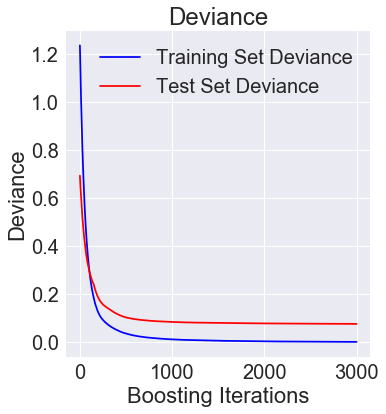

In [26]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf_final.staged_predict(X_important_test)):
    test_score[i] = clf_final.loss_(y_test.values.ravel(), y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_final.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

## RandomizedSearch cross-validation: when there's not enough time for GridSearch
We used the feature_selection package to pare down our feature list to some important ones.  
Now the **model_selection** package will help us to explore the hyperparameter space 
and pin down the right combination of hyperparameters that gives us the best model.  

[**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) exhaustively loops through every combination of user-supplied lists of hyperparameters - 
with more than a few parameters, and more than a few values tried for each parameter, 
this can compound into a lot of iterations.  

[**RandomizedSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) 
only calculates for randomly 
selected parameter sets, 
selected from user-supplied distribution 
functions (here listed in `param_dist`).  
It can save a lot of time without 
degradation in performance. Consider a case where
it doesn't matter whether
`min_samples_leaf` is 2 or 20 or anything in-between.
One key benefit of RandomizedSearch over
GridSearch is that including parameters that have no 
effect on performance does not harm
efficiency, since in RandomizedSearch the
unimportant parameters aren't constantly
iterated over combinations with other parameters.
Instead, the search is limited to a budget 
of `n_iter` samples randomly chosen, where
randomization still allows for a good exploration
of the entire parameter space.

Distribution functions sp_randint and sp_uniform
come from the scipy.stats package and return uniformly
distributed integer and float random variables.

`n_iter_search` defines how many different hyperparameter combos
you'd like to collect.  The higher the number, the more
thoroughly you explore your parameter space, but also
the longer it will take.  The search
took 600s to fit for `n_iter_search=1000`
and `n_estimators` limited to less than 200.

In [27]:
clf_cv = skl.ensemble.GradientBoostingRegressor()

In [28]:
param_dist = {"n_estimators":sp_randint(50,200),
              "max_features":sp_uniform(loc=0.4,scale=0.5),
              "min_samples_leaf":sp_randint(1,20),
              "min_samples_split":sp_randint(2,25),
              "max_depth":sp_randint(2,8),
              "subsample":sp_uniform(loc=.5,scale=.5),
             }

In [29]:
n_iter_search=1000
random_search=skl.model_selection.RandomizedSearchCV(clf_cv,
                                                     param_distributions=param_dist,
                                                     n_iter=n_iter_search,
                                                     n_jobs=-1
                                                    )

In [30]:
start=time()
random_search.fit(X_important_train,y_train.values.ravel())
print("RandomizedSearchCV took %.2f seconds for %d iterations"
      % ((time() - start), n_iter_search))

RandomizedSearchCV took 601.40 seconds for 1000 iterations


Let's print out the info for the highest-ranking models.
Hopefully a winning list of hyperparameters will emerge!

In [31]:
report(random_search.cv_results_,n_top=10)

Model with rank: 1
Mean validation score: 0.857 (std: 0.040)
Parameters: {'max_depth': 3, 'max_features': 0.7676442219232984, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 116, 'subsample': 0.95747652248816706}

Model with rank: 2
Mean validation score: 0.856 (std: 0.062)
Parameters: {'max_depth': 7, 'max_features': 0.70581721115630947, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 163, 'subsample': 0.59056647078808133}

Model with rank: 3
Mean validation score: 0.856 (std: 0.067)
Parameters: {'max_depth': 6, 'max_features': 0.87147513886371786, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 181, 'subsample': 0.91091319596145959}

Model with rank: 4
Mean validation score: 0.856 (std: 0.026)
Parameters: {'max_depth': 5, 'max_features': 0.46165707922687016, 'min_samples_leaf': 7, 'min_samples_split': 14, 'n_estimators': 168, 'subsample': 0.82301293894656791}

Model with rank: 5
Mean validation score: 0.855 (std: 0.050)
Parameters: {'max

To further improve performance we can 
halve the learning rate and double n_estimators,
or apply some other appropriately proportional
tuning.

If hand-tuning parameters is more your style, 
you can try a _greedy_ cross-validation scheme, 
where hyperparameters are tuned and fixed one by one.

A nicely laid out approach is outlined [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).  
The hyperparameters are tuned in a specific order, 
with the more important parameters appearing first:
1. Tune an appropriate balance of `n_estimators` and `learning_rate`
2. Tune tree parameters:
   1. `max_depth` and `num_samples_split`
   2. `min_samples_leaf`
   3. `max_features`
3. Lower `learning_rate` as you increase `n_estimators`